ROMAIN LAVAL

# TP noté Maths pour l'IA: Identifier un locuteur

Pour ce TP, vous aurez accès à vos cours et notes des précédents TPs. Normalement vous aurez tout ce qu'il faut.

La tâche d'identification du locuteur consiste à apprendre des modèles de locuteurs connus suivant leur identifiant, et ensuite associer l'enregistrement d'un locuteur inconnu avec un des identifiants.
Pour cela, les techniques récentes utilisent des représentations de locuteurs apprises sur de grandes quantités de données appelées *speaker embeddings*. Ces représentations sont des vecteurs de grande dimension qui capturent l'identité vocale des locuteurs.

Les locuteurs apparaissent plusieurs fois dans le corpus, on a plusieurs extraits audio (segments de parole) où un même locuteur apparait.

A partir d'un signal de parole correspondant à un locuteur connu, on extrait un vecteur d'*embeddings*. Ces locuteurs feront partie de l'enrollement. On obtient alors une modélisation acoustique pour chaque locuteur de notre partition d'enrollement.

En phase de test, on récupère un extrait de signal de parole correspondant à un unique locuteur que l'on ne connait pas. On extrait à partir de ce signal le vecteur d'*embeddings* associé et on va chercher l'identifiant correspondant au vecteur d'*embeddings* du locuteur de l'enrollement le plus similaire. On calculera un taux d'erreur suivant la distance utilisée à partir des identifiants des locuteurs inconnus présent dans la partition de test.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## Partie 1 : Analyse en composantes principales

Le vecteur d'*embeddings* qui représente un locuteur est de grande dimension (256). Pour accélérer les calculs, nous allons utiliser l'analyse en composantes principales pour réduire cette dimension.

### 1.1. Visualiser les données

Construire une fonction `nuage` qui prendra en argument deux vecteurs, des labels au format `int` et les titres des axes (abscisses et ordonnées). Cette fonction devra afficher les données (x,y) sous forme d'un nuage de points.

In [3]:
# chargement des données
enroll_ids = np.load("enroll_ids.npy")#identifiants des locuteurs connus
enroll_xv = np.load("enroll_xv.npy")  #vecteurs d'embeddings des loc connus

test_ids = np.load("test_ids.npy")    #identifiants des locuteurs inconnus => pour vérifier
test_xv = np.load("test_xv.npy")      #vecteurs d'embeddings des loc inconnus

In [4]:
#affichage du nuage de points en 2D
def nuage(x1, x2, y, dim1='dim1', dim2='dim2'):

    plt.scatter(x1, x2);
    plt.xlabel(dim1);
    plt.ylabel(dim2);

    i = 0
    for label in y:
        plt.annotate(label, (x1[i], x2[i]));
        i += 1;

    plt.show();
    

### 1.2 Réduire la dimension

A l'aide de `sklearn` réaliser une ACP afin de ne récupérer que les 50 composantes ayant une entropie maximum.
La matrice obtenue a une dimension (1111,32), préciser à quoi correspondent ces dimensions.

Afficher avec la fonction `nuage` les deux composantes principales.

(1111, 50)


TypeError: 'int' object is not iterable

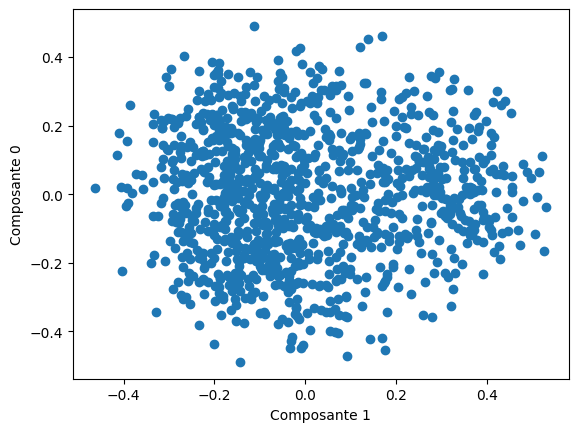

In [5]:
# transformer les identifiants nom_prenom des locuteurs en suite d'entiers.
enroll_ids_num = np.unique(enroll_ids,return_inverse=True)[1]

pca = PCA(50)
enroll_xv_pca = pca.fit_transform(enroll_xv)
test_xv_pca = pca.fit_transform(test_xv)

print(enroll_xv_pca.shape)
#La dimension est (1111, 50) car il y a 1111 locuteurs et on garde que les 50 meilleurs composantes

nuage(enroll_xv_pca[:,0], enroll_xv_pca[:,1], enroll_ids_num, "Composante 1", "Composante 0")


### 1.3. Interpréter

Sur le nuage de points obtenu avec les deux premières composantes principales, on ne voit pas de regroupement évident en locuteur. On distingue éventuellement un étalement sur la première composante qui pourrait correspondre au genre des locuteurs.

**Q1** Donner la contribution en pourcentage par rapport à l'inertie totale de la première composante, puis des 50 premières composantes. Donner une interprétation du manque de discrimination entre les locuteurs avec la PCA.

**Q2** Donner la dimension de la matrice de passage correspondant à la décomposition de la matrice d'*embeddings*.

**Q3** Parmi les 256 dimensions du vecteur d'*embeddings* quelle dimension contribue le plus à la composante principale ?

## Partie 2 : Identifier les locuteurs

### 3.1. Définir les similarités

Nous utiliserons deux similarités pour évaluer à quel point un locuteur inconnu (de la partition de test) est proche de chacun des locuteurs de la partition d'enrollement: 
* similarité cosinus => le locuteur inconnu sera identifié par le locuteur d'enrollement qui a une similarité maxium
* distance de Manhattan => le locuteur inconnu sera identifié par le locuteur d'enrollement qui a une distance minimum

Définir deux fonctions qui calculent la distance manhattan et la similarité cosinus entre un vecteur de dimension $n$ et une matrice de dimension $m\times n$ et retournent un vecteur de similarités de dimension $m$. A minima vos fonctions doivent prendre en compte $m=1$.

In [111]:
def L1norm(x):

    if(len(x.shape) == 1):
        return x.sum()

    return x.sum(axis=1)

    # calcule la norme 1 sur la première dimension
    # x: vecteur (n,) ou matrice de dimension (n,m)
    # retourne : vecteur de dimension (m,)

def manhattan(x,y):

    res = np.zeros(y.shape[0])

    i = 0
    for v in y:

        res[i] = np.abs(x - y).sum(axis=1)[i]
        i+=1


    return res

    #x: vecteur de dimension (n,)
    # y: matrice de dimension (m,n)
    # retourne: vecteur de dimension (m,)

#def sim_cos(x,y):
    # x: vecteur de dimension (n,)
    # y: matrice de dimension (m,n)
    # retourne: vecteur de dimension (m,)

In [112]:
manhattan(np.ndarray((3,)), np.ndarray((8,3)))

array([72.75, 73.  , 74.  , 74.25, 74.25, 74.  , 73.  , 72.75])

### 3.2. Calculer un taux d'erreur sur les vecteurs complets

Pour un locuteur inconnu de la partition de test, on cherchera l'identifiant du locuteur de la partition d'enrollement qui a le plus grand score de similarité, ou la plus petite distance. On considère alors que cet identifiant correspond au locuteur prédit.

En comparant l'identifiant du locuteur prédit avec celui du locuteur de référence, on peut évaluer les performances de notre approche en calculant un taux d'erreur (nombre de bonnes réponses / nombre de locuteurs inconnus).

Vous devrez trouver des taux autour de 91% de bonnes réponses.

### 3.3. Calculer un taux d'erreur sur les vecteurs réduits

Reprendre la question précédente en utilisant cette fois-ci les vecteurs de dimension réduite à 64 issus de l'analyse en composante principale.

### 3.4 Interpétation

**Q1.** Le modèle qui a permis d'apprendre les *embeddings* a été entraîné avec une similarité cosinus. Est-ce que cette mesure de similarité est bien celle qui donne le meilleur taux de reconnaissance ?

**Q2.** Comparer les taux de reconnaissance avec les vecteurs d'*embeddings* complets ou bien leur version réduite. Qu'en pensez-vous ?

--------